In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

ee.Initialize()
print("Earth Engine ready.")

Earth Engine ready.


In [2]:
def make_city_bbox(lon, lat, half_deg=0.25):
    return ee.Geometry.Rectangle([
        lon - half_deg, lat - half_deg,
        lon + half_deg, lat + half_deg
    ])

CITIES = {
    "Kabul":     {"lat": 34.53, "lon": 69.17},
    "Herat":     {"lat": 34.34, "lon": 62.17},
    "Mazar":     {"lat": 36.71, "lon": 67.11},
    "Kandahar":  {"lat": 31.62, "lon": 65.72},
    "Jalalabad": {"lat": 34.43, "lon": 70.45}
}

for city, info in CITIES.items():
    info["geom"] = make_city_bbox(info["lon"], info["lat"])

In [3]:
start = ee.Date("2019-01-01")
end   = ee.Date("2025-01-01")

In [4]:
NO2_COLLECTION = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2")
    .select("tropospheric_NO2_column_number_density")
)

def get_monthly_no2_for_city(city_name, geom, start_date, end_date):
    n_months = end_date.difference(start_date, "month").int()
    month_indices = ee.List.sequence(0, n_months.subtract(1))

    def monthly_feature(m):
        m = ee.Number(m)
        start_m = start_date.advance(m, "month")
        end_m   = start_m.advance(1, "month")

        coll = NO2_COLLECTION.filterDate(start_m, end_m).filterBounds(geom)
        img = coll.mean()

        mean_dict = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=1000,
            bestEffort=True
        )

        return ee.Feature(None, {
            "city": city_name,
            "month_start": start_m.format("YYYY-MM-dd"),
            "no2": mean_dict.get("tropospheric_NO2_column_number_density")
        })

    fc = ee.FeatureCollection(month_indices.map(monthly_feature))
    data = fc.getInfo()

    rows = []
    for f in data["features"]:
        rows.append({
            "city": f["properties"]["city"],
            "month_start": f["properties"]["month_start"],
            "no2": f["properties"]["no2"]
        })

    df = pd.DataFrame(rows)
    df["month_start"] = pd.to_datetime(df["month_start"])
    df = df.sort_values("month_start")
    return df.dropna()


In [5]:
CO_COLLECTION = (
    ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO")
    .select("CO_column_number_density")
)

def get_monthly_co_for_city(city_name, geom, start_date, end_date):
    n_months = end_date.difference(start_date, "month").int()
    month_indices = ee.List.sequence(0, n_months.subtract(1))

    def monthly_feature(m):
        m = ee.Number(m)
        start_m = start_date.advance(m, "month")
        end_m   = start_m.advance(1, "month")

        coll = CO_COLLECTION.filterDate(start_m, end_m).filterBounds(geom)
        img = coll.mean()

        mean_dict = img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geom,
            scale=1000,
            bestEffort=True
        )

        return ee.Feature(None, {
            "city": city_name,
            "month_start": start_m.format("YYYY-MM-dd"),
            "co": mean_dict.get("CO_column_number_density")
        })

    fc = ee.FeatureCollection(month_indices.map(monthly_feature))
    data = fc.getInfo()

    rows = []
    for f in data["features"]:
        rows.append({
            "city": f["properties"]["city"],
            "month_start": f["properties"]["month_start"],
            "co": f["properties"]["co"]
        })

    df = pd.DataFrame(rows)
    df["month_start"] = pd.to_datetime(df["month_start"])
    df = df.sort_values("month_start")
    return df.dropna()


In [6]:
df_no2_kabul = get_monthly_no2_for_city("Kabul", CITIES["Kabul"]["geom"], start, end)
df_co_kabul  = get_monthly_co_for_city("Kabul", CITIES["Kabul"]["geom"], start, end)

In [7]:
df_kabul = pd.merge(
    df_no2_kabul, 
    df_co_kabul, 
    on=["city", "month_start"],
    how="inner"
)

df_kabul.head()

,city,month_start,no2,co
0,Kabul,2019-01-01,0.000054,0.027708
1,Kabul,2019-02-01,0.000041,0.026902
2,Kabul,2019-03-01,0.000038,0.026891
3,Kabul,2019-04-01,0.000039,0.027204
4,Kabul,2019-05-01,0.000038,0.025931


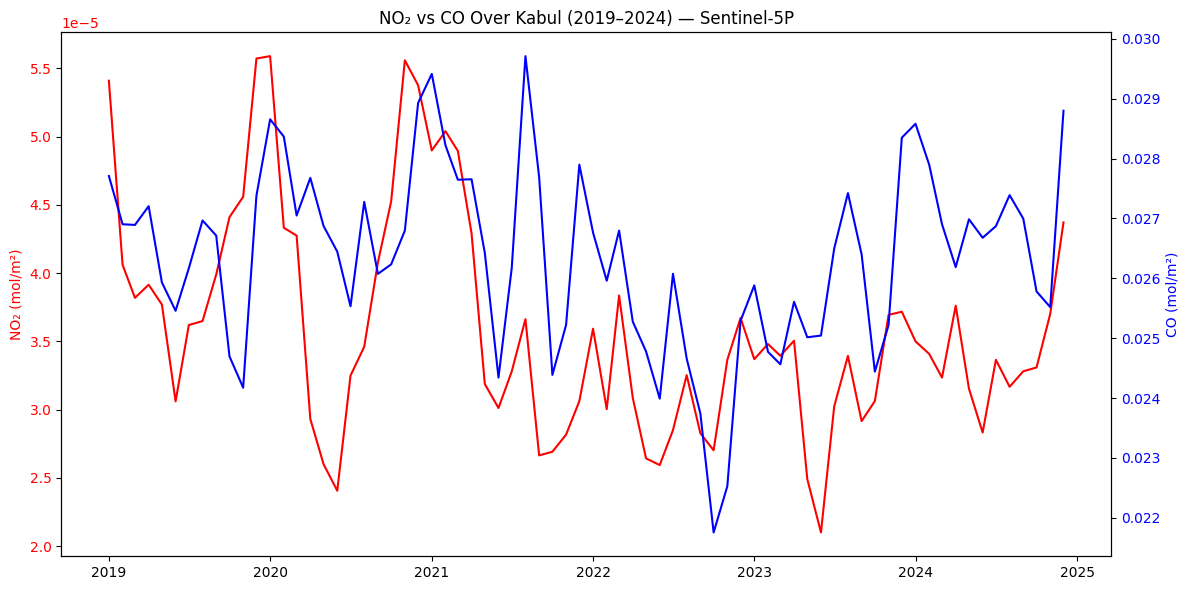

In [8]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df_kabul["month_start"], df_kabul["no2"], color="red", label="NO₂")
ax1.set_ylabel("NO₂ (mol/m²)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(df_kabul["month_start"], df_kabul["co"], color="blue", label="CO")
ax2.set_ylabel("CO (mol/m²)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")

plt.title("NO₂ vs CO Over Kabul (2019–2024) — Sentinel-5P")
plt.xlabel("Month")

fig.tight_layout()
plt.show()

### Interpretation

The dual-axis plot shows that both NO₂ and CO exhibit strong winter peaks every year from 2019–2024, driven by increased fuel use for heating, lower atmospheric mixing, and more combustion sources in colder months.

NO₂ peaks are closely tied to traffic and generator use, while CO peaks can additionally reflect trash burning and incomplete combustion. The correlation plot shows a positive relationship, indicating that many combustion processes increase both pollutants simultaneously. Divergences (e.g., high CO but moderate NO₂) may point to changes in fuel types or burning practices.

In [9]:
df_kabul["month"] = df_kabul["month_start"].dt.month
df_kabul["year"]  = df_kabul["month_start"].dt.year
df_kabul.head()

,city,month_start,no2,co,month,year
0,Kabul,2019-01-01,0.000054,0.027708,1,2019
1,Kabul,2019-02-01,0.000041,0.026902,2,2019
2,Kabul,2019-03-01,0.000038,0.026891,3,2019
3,Kabul,2019-04-01,0.000039,0.027204,4,2019
4,Kabul,2019-05-01,0.000038,0.025931,5,2019


In [10]:
seasonal_no2 = (
    df_kabul.groupby("month")["no2"]
    .mean()
    .reset_index()
)

seasonal_co = (
    df_kabul.groupby("month")["co"]
    .mean()
    .reset_index()
)

seasonal_no2, seasonal_co

(    month       no2
 0       1  0.000044
 1       2  0.000039
 2       3  0.000039
 3       4  0.000036
 4       5  0.000030
 5       6  0.000027
 6       7  0.000032
 7       8  0.000034
 8       9  0.000033
 9      10  0.000035
 10     11  0.000040
 11     12  0.000043,
     month        co
 0       1  0.027833
 1       2  0.027019
 2       3  0.026641
 3       4  0.026601
 4       5  0.026001
 5       6  0.025326
 6       7  0.026219
 7       8  0.027237
 8       9  0.026268
 9      10  0.024549
 10     11  0.024909
 11     12  0.027773)

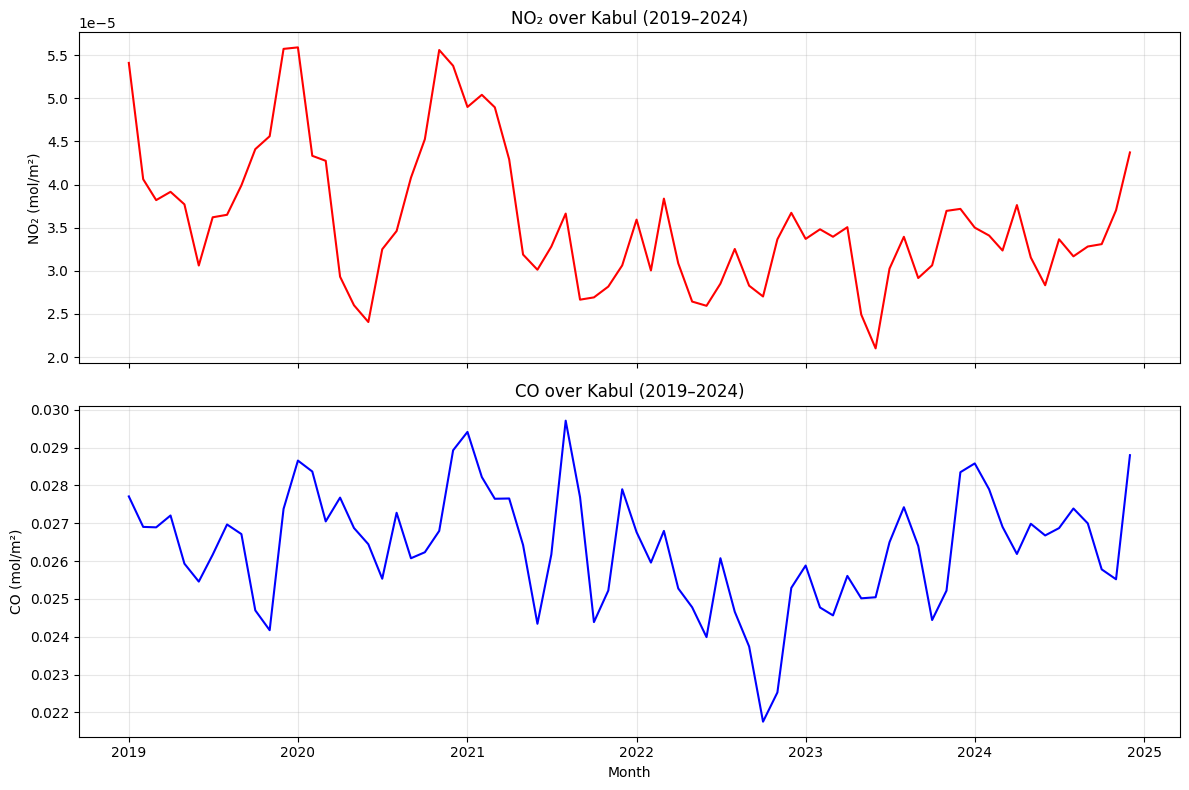

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# NO2
ax1.plot(df_kabul["month_start"], df_kabul["no2"], color="red")
ax1.set_title("NO₂ over Kabul (2019–2024)")
ax1.set_ylabel("NO₂ (mol/m²)")
ax1.grid(alpha=0.3)

# CO
ax2.plot(df_kabul["month_start"], df_kabul["co"], color="blue")
ax2.set_title("CO over Kabul (2019–2024)")
ax2.set_ylabel("CO (mol/m²)")
ax2.set_xlabel("Month")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


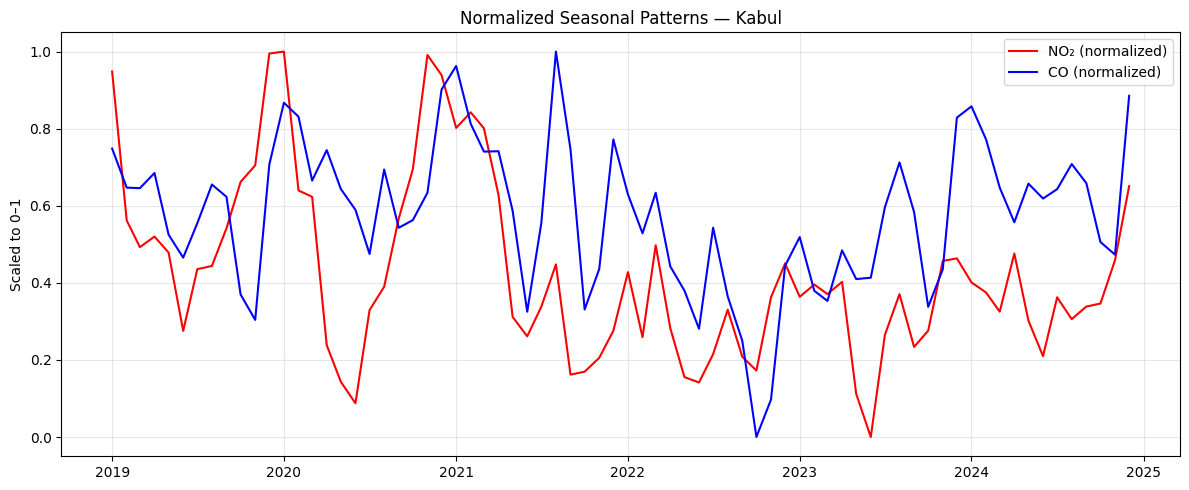

In [17]:
df_norm = df_kabul.copy()

df_norm["no2_norm"] = (df_norm["no2"] - df_norm["no2"].min()) / (df_norm["no2"].max() - df_norm["no2"].min())
df_norm["co_norm"]  = (df_norm["co"]  - df_norm["co"].min())  / (df_norm["co"].max()  - df_norm["co"].min())

plt.figure(figsize=(12,5))
plt.plot(df_norm["month_start"], df_norm["no2_norm"], label="NO₂ (normalized)", color="red")
plt.plot(df_norm["month_start"], df_norm["co_norm"],  label="CO (normalized)",  color="blue")
plt.legend()
plt.title("Normalized Seasonal Patterns — Kabul")
plt.ylabel("Scaled to 0–1")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
pivot_no2 = df_kabul.pivot(index="year", columns="month", values="no2")
pivot_no2


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2019,0.000054,0.000041,0.000038,0.000039,0.000038,0.000031,0.000036,0.000036,0.000040,0.000044,0.000046,0.000056
2020,0.000056,0.000043,0.000043,0.000029,0.000026,0.000024,0.000033,0.000035,0.000041,0.000045,0.000056,0.000054
2021,0.000049,0.000050,0.000049,0.000043,0.000032,0.000030,0.000033,0.000037,0.000027,0.000027,0.000028,0.000031
2022,0.000036,0.000030,0.000038,0.000031,0.000026,0.000026,0.000029,0.000033,0.000028,0.000027,0.000034,0.000037
2023,0.000034,0.000035,0.000034,0.000035,0.000025,0.000021,0.000030,0.000034,0.000029,0.000031,0.000037,0.000037
2024,0.000035,0.000034,0.000032,0.000038,0.000032,0.000028,0.000034,0.000032,0.000033,0.000033,0.000037,0.000044


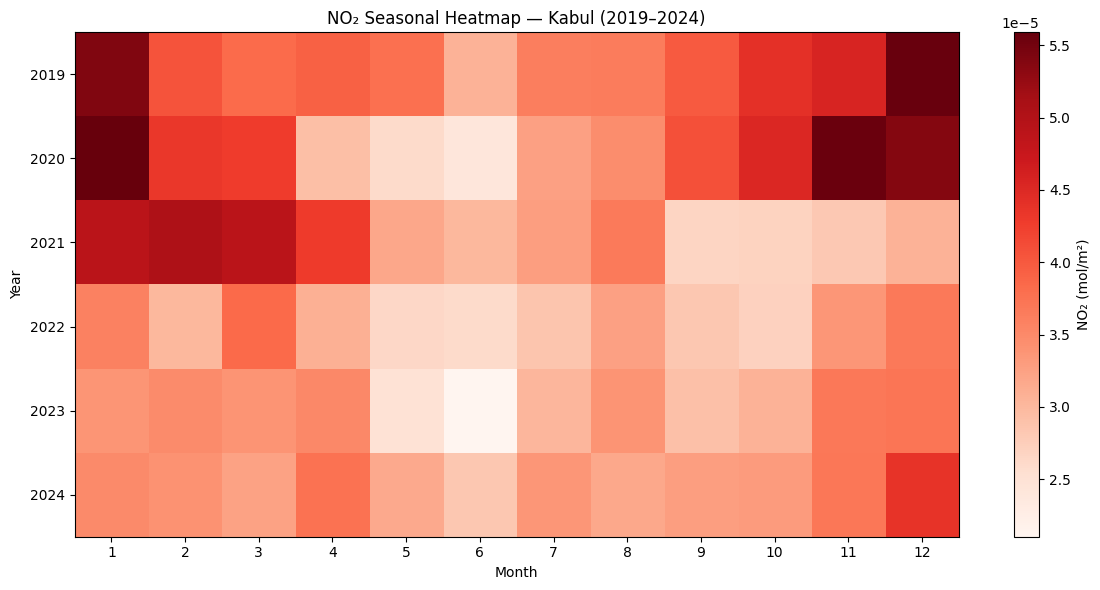

In [13]:
plt.figure(figsize=(12, 6))
plt.imshow(pivot_no2, aspect="auto", cmap="Reds")
plt.colorbar(label="NO₂ (mol/m²)")
plt.xticks(range(12), range(1,13))
plt.yticks(range(len(pivot_no2.index)), pivot_no2.index)
plt.title("NO₂ Seasonal Heatmap — Kabul (2019–2024)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


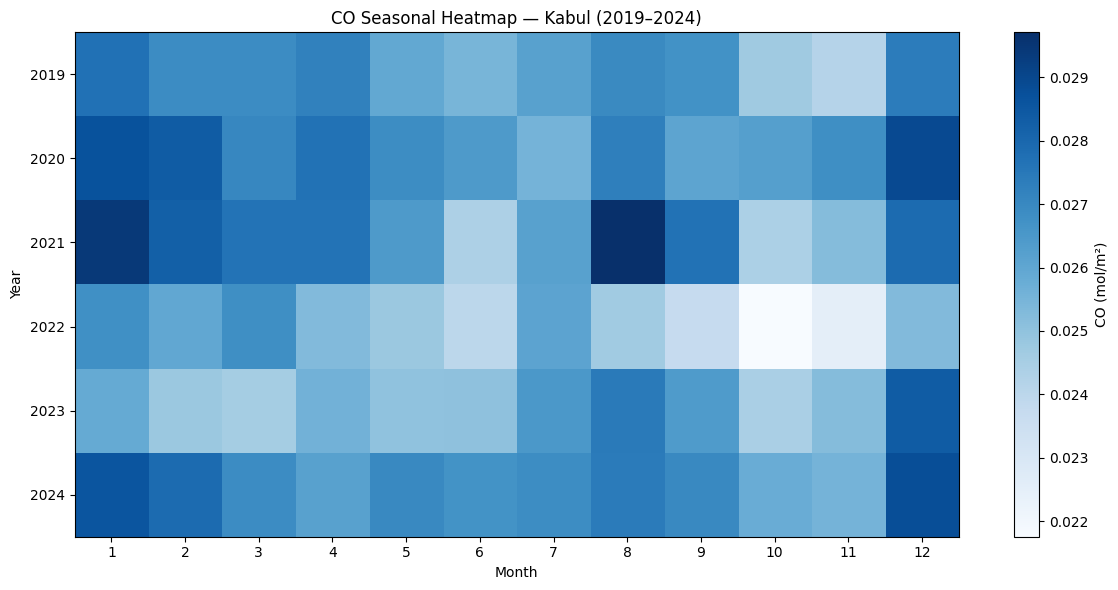

In [14]:
pivot_co = df_kabul.pivot(index="year", columns="month", values="co")

plt.figure(figsize=(12, 6))
plt.imshow(pivot_co, aspect="auto", cmap="Blues")
plt.colorbar(label="CO (mol/m²)")
plt.xticks(range(12), range(1,13))
plt.yticks(range(len(pivot_co.index)), pivot_co.index)
plt.title("CO Seasonal Heatmap — Kabul (2019–2024)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


### Interpretation of Seasonal Patterns

Both NO₂ and CO show strong seasonal cycles in Kabul. Pollution peaks sharply in winter (December–February) due to increased heating, combustion, and reduced atmospheric mixing. Summer months consistently show the lowest values, reflecting better ventilation and lower heating emissions.

The heatmaps show that these seasonal patterns persist across all years from 2019–2024, with some years (e.g., 2020–2021) exhibiting slightly lower pollution likely due to reduced mobility and economic activity around the COVID-19 period.

CO shows even stronger winter peaks than NO₂, highlighting additional combustion sources such as trash burning, diesel generators, and incomplete combustion during cold months.
